In [2]:
### Python imports
import nbimporter
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import pickle

####Importing  Data cleaning,scoring and confusion matrix from functions.ipynb(user created)
from functions import data_clean
from functions import training_predict
from functions import data_clean
from functions import confusion_matrix_plot




### Importing pipelines and preprocessors

from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,StandardScaler,RobustScaler
from sklearn.compose import ColumnTransformer


###Importing model selection and validation metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, average_precision_score ,auc,roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold

#### Importing models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier , StackingClassifier


### IMporting our sampling strategy
from imblearn.over_sampling import BorderlineSMOTE

### Importing Hyperopt and its helpers
from hyperopt import hp, tpe
from hyperopt.fmin import fmin



Importing Jupyter notebook from functions.ipynb


Using TensorFlow backend.


In [3]:
#### Reading dataset
data_train=pd.read_csv("exercise_01_train.csv")
#### Cleaning data using custom function
data_train=data_clean(data_train)

In [4]:

##target variable
labels=data_train["y"]
#### Rest of features
all_data=data_train.drop(columns=["y"])

##Numeric features
numeric_features =  all_data.select_dtypes(include=["float","int"]).columns
### Categorical features
categorical_features=all_data.select_dtypes(exclude=["float","int"]).columns

#### Selecting Median imputer as startegy for imputing missing values and Robust scaler as strategy for 
#### standardizing data.Since the missing values in EDA
####Robust scaler was slightly better at model performance than standard scaler 
####because of its robustness to outliers


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

#### Selecting simple imputer as startegy for imputing missing values to "missing" category 
#### Onehot encoding  as next step in pipeline for categorical variables




categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])




##### Applying preprocessing steps as column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],remainder="passthrough")



In [17]:
#### Tuning for xgboost was done at smote ratio of 0.32 and on few obvious chosen hyperparameters of xgboost such as
### n_estimators,max depth, min_child_weight and regularization lambda.The xgboost model in its base form had a 
### great performance and by model tuning I was able to only get a marginal imporovement in auc performance
### from 0.9838 to 0.9845.This final model was pickled and result2 predictions were taken from this model.






start_time=time.time()

#### Create X and Y training data here.....

sm = BorderlineSMOTE(0.32,kind='borderline-1',random_state=42)
# grid search
XGB = XGBClassifier()
cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

pipe=Pipeline([('preprocessor', preprocessor),("SMOTE",sm), ('XGB', XGB)])


param_grid = {'XGB__n_estimators':[100,200,300],
    'XGB__max_depth': range(5),
              'XGB__min_child_weight':[1,2,3,4,5], 
              'XGB__reg_lambda': [0.50,0.75,1,1.25,1.5]}


grid_search = RandomizedSearchCV(pipe, param_grid, scoring="roc_auc", cv=cv,verbose=2)
grid_result = grid_search.fit(X_train,y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_[ 'mean_test_score' ]
stds = grid_result.cv_results_[ 'std_test_score' ]
params = grid_result.cv_results_[ 'params' ]

print(time.time()-start_time)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] XGB__reg_lambda=0.5, XGB__n_estimators=200, XGB__min_child_weight=3, XGB__max_depth=3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  XGB__reg_lambda=0.5, XGB__n_estimators=200, XGB__min_child_weight=3, XGB__max_depth=3, total= 1.4min
[CV] XGB__reg_lambda=0.5, XGB__n_estimators=200, XGB__min_child_weight=3, XGB__max_depth=3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV]  XGB__reg_lambda=0.5, XGB__n_estimators=200, XGB__min_child_weight=3, XGB__max_depth=3, total= 1.5min
[CV] XGB__reg_lambda=0.5, XGB__n_estimators=200, XGB__min_child_weight=3, XGB__max_depth=3 
[CV]  XGB__reg_lambda=0.5, XGB__n_estimators=200, XGB__min_child_weight=3, XGB__max_depth=3, total= 1.3min
[CV] XGB__reg_lambda=0.5, XGB__n_estimators=200, XGB__min_child_weight=3, XGB__max_depth=3 
[CV]  XGB__reg_lambda=0.5, XGB__n_estimators=200, XGB__min_child_weight=3, XGB__max_depth=3, total= 1.5min
[CV] XGB__reg_lambda=0.5, XGB__n_estimators=200, XGB__min_child_weight=3, XGB__max_depth=3 
[CV]  XGB__reg_lambda=0.5, XGB__n_estimators=200, XGB__min_child_weight=3, XGB__max_depth=3, total= 1.3min
[CV] XGB__reg_lambda=1.5, XGB__n_estimators=200, XGB__min_child_weight=5, XGB__max_depth=3 
[CV]  XGB__reg_lambda=1.5, XGB__n_estimators=200, XGB__min_child_weight=5, XGB__max_depth=3, total= 1.3min
[CV] XGB__reg_lambda=1.5, XGB__n_estimators=200, XGB__min_child_weight=5, XGB__max_depth=3 
[CV] 

[CV]  XGB__reg_lambda=1, XGB__n_estimators=200, XGB__min_child_weight=2, XGB__max_depth=4, total= 1.7min
[CV] XGB__reg_lambda=1, XGB__n_estimators=200, XGB__min_child_weight=2, XGB__max_depth=4 
[CV]  XGB__reg_lambda=1, XGB__n_estimators=200, XGB__min_child_weight=2, XGB__max_depth=4, total= 1.6min
[CV] XGB__reg_lambda=1, XGB__n_estimators=100, XGB__min_child_weight=1, XGB__max_depth=4 
[CV]  XGB__reg_lambda=1, XGB__n_estimators=100, XGB__min_child_weight=1, XGB__max_depth=4, total= 1.2min
[CV] XGB__reg_lambda=1, XGB__n_estimators=100, XGB__min_child_weight=1, XGB__max_depth=4 
[CV]  XGB__reg_lambda=1, XGB__n_estimators=100, XGB__min_child_weight=1, XGB__max_depth=4, total= 1.2min
[CV] XGB__reg_lambda=1, XGB__n_estimators=100, XGB__min_child_weight=1, XGB__max_depth=4 
[CV]  XGB__reg_lambda=1, XGB__n_estimators=100, XGB__min_child_weight=1, XGB__max_depth=4, total= 1.1min
[CV] XGB__reg_lambda=1, XGB__n_estimators=100, XGB__min_child_weight=1, XGB__max_depth=4 
[CV]  XGB__reg_lambda=1, 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 127.6min finished


Best: 0.986064 using {'XGB__reg_lambda': 1.5, 'XGB__n_estimators': 300, 'XGB__min_child_weight': 4, 'XGB__max_depth': 4}
7839.487818956375


In [63]:
###result of best model on training cross validation(AUC)
grid_result.best_score_

0.9860640332893993

In [6]:

# pickle.dump(grid_result.best_estimator_,open("best_model.sav","wb"))
# pickle.dump(grid_result.best_estimator_,open("best_model.pkl","wb"))
xgboost_best1=pickle.load(open("best_model.pkl", 'rb'))

test results for final xgboost model :
{'auc': 0.9845318331918554, 'AP-SCORE': 0.9752471976664003, 'Recall_test': 0.906152889993785, 'Precision_test': 0.9745989304812834, 'F1_Score_test': 0.9391304347826086}
Confusion matrix, without normalization
Normalized confusion matrix


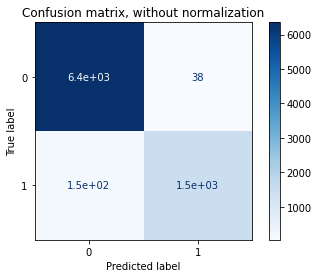

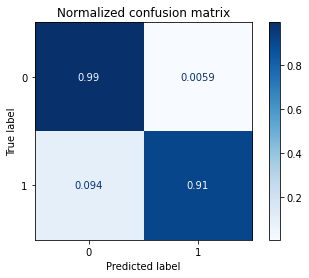

In [27]:
### Test results for final xgb model
model_xgb1=xgboost_best1
model_xgb1.fit(X_train,y_train)
# print("test results for final xgboost model :")
# print(training_predict(model_xgb1,X_train,y_train,X_test,y_test))
# confusion_matrix_plot(model_xgb1,X_test,y_test)  

In [7]:
model_xgb1=xgboost_best1
model_xgb1.fit(all_data,labels)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                      

In [9]:
#printing out predictions fro test dataset
# removes scientific notations from no nparray
np.set_printoptions(suppress=True)

data_test=pd.read_csv("exercise_01_test.csv")
#### Cleaning data using custom function
data_test=data_clean(data_test)
model_xgb1.predict_proba(data_test)[:,1]
np.savetxt("result2.csv",model_xgb1.predict_proba(data_test)[:,1])

In [10]:
prediction=model_xgb1.predict(data_test)

In [13]:
len(prediction[np.where(prediction==1)])

1898